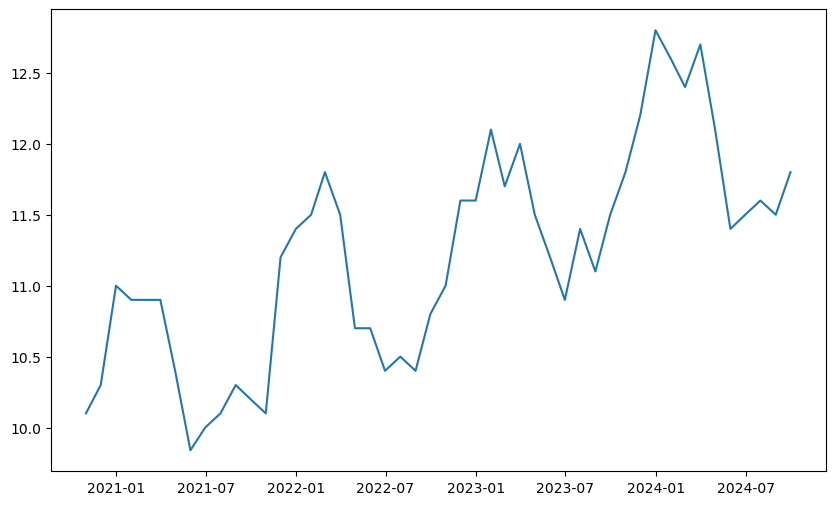

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
gas = pd.read_csv("Nat_Gas.csv")
gas.head(10)


prices = gas['Prices']
gas['Dates']=pd.to_datetime(gas['Dates'])


plt.figure(figsize = (10,6))
plt.plot(gas['Dates'],gas['Prices'])


In [2]:
#Let's attempt to see if theres any linearity with this series (Probably not thought)

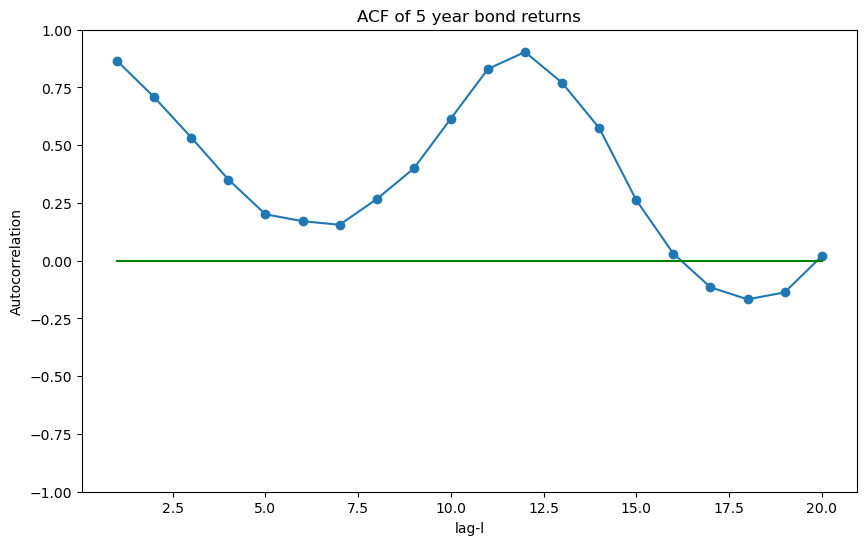

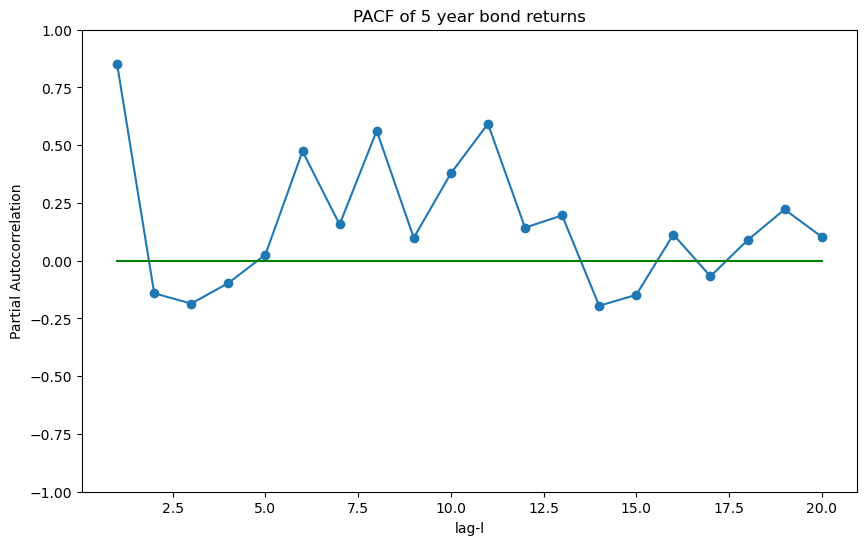

In [3]:
def AR(data,p):
    # r_t = x0 + x1 r_t-1 + x2 r_t-2...... 
    # for each data point 
    
    #for i in range(p):
    x= []
    y = []
    for i in range(0,len(data)-p):
        datax = []
        datay = []
        for j in range(i,i+p):
            datax.append(data[j])
        datay.append(data[i+p])
        x.append(datax)
        y.append(datay)
    
    x = pd.DataFrame(x)
    y = pd.DataFrame(y)
    
    model = LinearRegression()
    model.fit(x,y)
    
    coefficients = model.coef_[0]
    rev_coefficients = coefficients[::-1]
    #print(coefficients)
    #print(rev_coefficients)
    
    intercept = model.intercept_
    
    ans = np.append(intercept,rev_coefficients)
    #print(f'ans is {ans}')
    return ans

def generate_acf(data, lag):
    #print(data.head(15))
    lags = [x for x in range(1,lag+1)]
    vals = []
    for l in range(1,lag+1):
        #print(f'lag is {l}')
        x = data[0:len(data)-l]
        y = data[l:]
        corr = np.corrcoef(x,y)[0,1]
        #print(f'corr is {corr} for lag {l}')
        vals.append(corr)
    plt.figure(figsize = (10,6))
    plt.plot(lags,vals,marker='o',linestyle='-')
    plt.title("ACF of 5 year bond returns")
    plt.xlabel("lag-l")
    plt.ylabel("Autocorrelation")
    plt.ylim(-1,1)
    plt.plot(lags,[0]*lag,linestyle='-',color='green')

def generate_pacf(data, lag):
    lags = [x for x in range(1,lag+1)]
    vals = []
    for l in range(1,lag+1):
        coeffs = AR(data,l)
        vals.append(coeffs[l])
    plt.figure(figsize=(10,6))
    plt.plot(lags,vals,marker='o',linestyle='-')
    plt.title("PACF of 5 year bond returns")
    plt.xlabel("lag-l")
    plt.ylabel("Partial Autocorrelation")
    plt.ylim(-1,1)
    plt.plot(lags,[0]*lag,linestyle='-',color='green')
    
    
generate_acf(prices,20)
generate_pacf(prices,20)




In [4]:
# Lets test for stationarity in time series:

from statsmodels.tsa.stattools import adfuller

results = adfuller(prices)

adf_stat = results[0]
p_val = results[1]

print(f'ADF-Fuller test statistic is {adf_stat} and p-value is {p_val}')

# We most likely need to difference the data 

ADF-Fuller test statistic is 0.21807686169999477 and p-value is 0.973257438844869


In [5]:
gas['Prices_diff'] = gas['Prices'].diff(periods=12)
gas['Prices_diff'].fillna(method = 'backfill',inplace = True)


# We also need the month index to be an exogenous(however its spelled) index

gas['Month'] = gas['Dates'].dt.month
gas.head(15)


,Dates,Prices,Prices_diff,Month
0,2020-10-31,10.10,0.0,10
1,2020-11-30,10.30,0.0,11
2,2020-12-31,11.00,0.0,12
3,2021-01-31,10.90,0.0,1
4,2021-02-28,10.90,0.0,2
5,2021-03-31,10.90,0.0,3
6,2021-04-30,10.40,0.0,4
7,2021-05-31,9.84,0.0,5
8,2021-06-30,10.00,0.0,6
9,2021-07-31,10.10,0.0,7


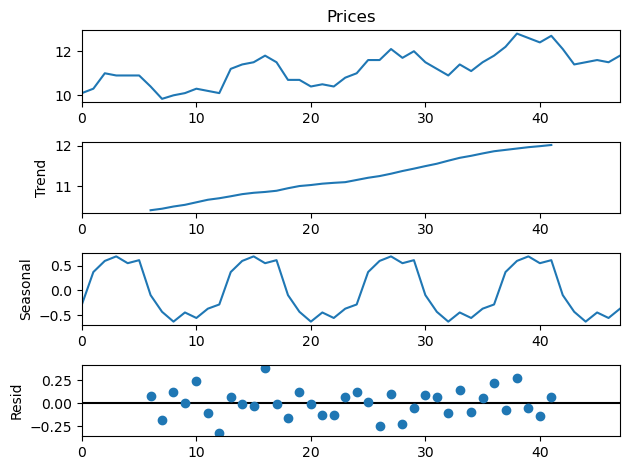

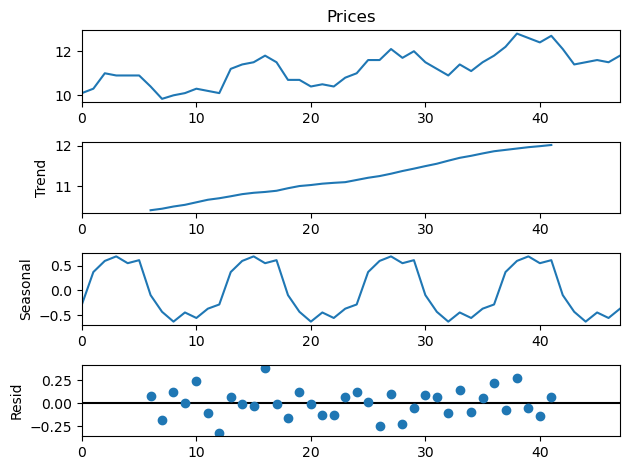

In [6]:
#Perform seasonal decomposition


from statsmodels.tsa.seasonal import seasonal_decompose

analysis = prices.copy()
decompose_results = seasonal_decompose(analysis, model = 'additive',period = 12)

trend = decompose_results.trend
seasonal= decompose_results.seasonal
residual = decompose_results.resid

decompose_results.plot()

#The following show that there is a linear increase in the trend of the gas prices, with a seasonal component that adheres
#closely to the schedule of the seasons as expected.

# To model the following prices, lets utilize a SARIMAX time series model

In [8]:
!pip install pmdarima -q

In [7]:

import pmdarima as pm

# Fits models with given p, q and d range and returns best model by performance metric

SARIMAX_model = pm.auto_arima(gas[['Prices']],exogenous=gas[['Month']],start_p=1,
                              start_q = 1,test = 'adf',max_p = 12, max_q=12,m=12,
                              start_P=0,seasonal = True,d=None,D =1, trace = False,
                             error_action = 'ignore',supress_warnings=True,stepwise = True)

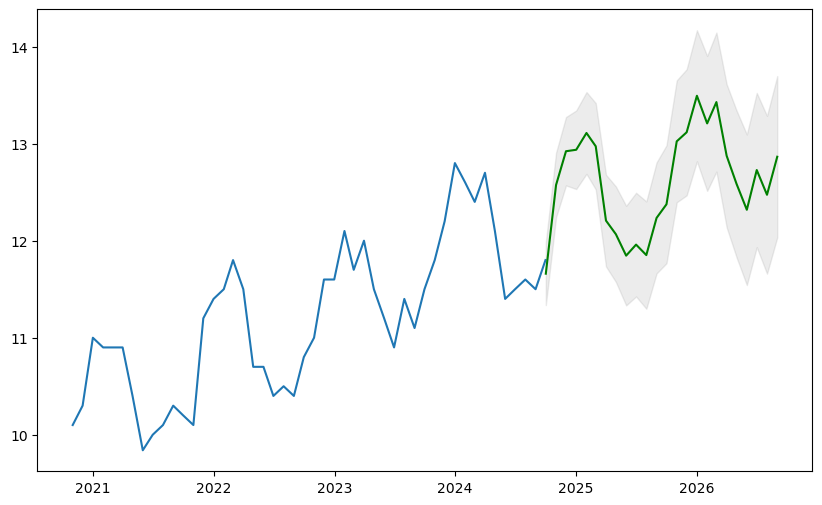

In [8]:
# Let's perform the forecasting now 

n_periods = 24

forecast_prices = pd.DataFrame({"Date":pd.date_range(gas['Dates'].iloc[-1],periods = n_periods,freq = 'MS')})
forecast_prices.head(10)
forecast_prices['Month'] = forecast_prices['Date'].dt.month

fitted, conf = SARIMAX_model.predict(n_periods = n_periods, return_conf_int = True, exogenous=forecast_prices[['Month']],)
index_dates = pd.date_range(gas['Dates'].iloc[-1],periods = n_periods, freq='MS')

fitted = pd.DataFrame(fitted)
fitted['Date']=index_dates
fitted = fitted.set_index(['Date'])

plt.figure(figsize=(10,6))
plt.plot(gas['Dates'],gas['Prices'])
plt.plot(fitted,color ='green')


lower_conf = pd.Series(conf[:,0])
upper_conf = pd.Series(conf[:,1])

plt.fill_between(fitted.index,lower_conf,upper_conf,color ='gray',alpha = 0.15)

In [9]:
#Let's concatenate our fitted results to our existing data Frame

#Give the prices in the fitted DF a name
col_names = list(fitted.columns)
col_names[0]='Price'

fitted.columns = col_names

# Get the historical prices in the same format
historical_prices = pd.DataFrame({'Date':gas['Dates'],'Price':gas['Prices']})
historical_prices = historical_prices.set_index(['Date'])

# Merge them together
fitted = pd.concat([historical_prices,fitted])

    

In [10]:
import datetime
# lets create a utility function to predict the price given a date
from dateutil.relativedelta import relativedelta

#print(fitted.index[-1])
#print(pd.date_range(fitted.index[-1],periods=12,freq = 'MS')[1:])
def predict_price(input_date,fitted):
    date = pd.to_datetime(input_date)
    
    start_date = date.replace(day=1)
    next_month = date.replace(day=28) + datetime.timedelta(days =4)
    end_date = next_month-datetime.timedelta(days=next_month.day)
    #print(f'{start_date} {end_date}')
    if start_date in fitted.index:
        return fitted.at[start_date,'Price'],fitted
    elif end_date in fitted.index:
        return fitted.at[end_date,'Price'],fitted
    
    difference = relativedelta(start_date,fitted.index[-1])
    months = 12*difference.years + difference.months
    month_df = pd.DataFrame(fitted.index.month)
    #print(month_df)
    
    SARIMAX_model = pm.auto_arima(fitted['Price'],exogenous=month_df['Date'],start_p=1,
                              start_q = 1,test = 'adf',max_p = 12, max_q=12,m=12,
                              start_P=0,seasonal = True,d=None,D =1, trace = False,
                             error_action = 'ignore',supress_warnings=True,stepwise = True)
    
    more_fitted, conf = SARIMAX_model.predict(n_periods = months+1, return_conf_int = True, exogenous=month_df['Date'])
    
    index_dates = pd.date_range(fitted.index[-1],periods = months+2, freq='MS')[1:]
    print(f'{index_dates},{more_fitted}')
    new_fitted = pd.DataFrame({'Date':index_dates,'Price':more_fitted})
    new_fitted = new_fitted.set_index(['Date'])
    #print(f'{new_fitted}')
    
    fitted = pd.concat([fitted,new_fitted])
    print(f'{fitted}')
    return fitted.at[start_date,'Price'],fitted
    
    # Predict ahead by the required amount of months

price,new_df=predict_price('06/22/27',fitted)
print(price)

#print(predict_price('06/22/27',fitted))
#fitted = new_df
#print(fitted)

DatetimeIndex(['2026-10-01', '2026-11-01', '2026-12-01', '2027-01-01',
               '2027-02-01', '2027-03-01', '2027-04-01', '2027-05-01',
               '2027-06-01', '2027-07-01'],
              dtype='datetime64[ns]', freq='MS'),72    13.150893
73    13.580386
74    14.102108
75    13.990118
76    13.765670
77    14.065458
78    13.478797
79    12.828802
80    12.878675
81    13.029575
dtype: float64
                Price
Date                 
2020-10-31  10.100000
2020-11-30  10.300000
2020-12-31  11.000000
2021-01-31  10.900000
2021-02-28  10.900000
...               ...
2027-03-01  14.065458
2027-04-01  13.478797
2027-05-01  12.828802
2027-06-01  12.878675
2027-07-01  13.029575

[82 rows x 1 columns]
12.878674880711293


C:\Users\jerry\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [22]:
# Now that we have a function to predict price, lets write a model that can price a contract given certain parameters,


def price_contract_model(injection_dates, withdrawal_dates, injection_rate, injection_withdrawal_costs
                        , max_storage_volume, storage_cost_per_month):
    profit = 0
    for i in range(len(injection_dates)):
        global fitted
        inj_price,new_df = predict_price(injection_dates[i],fitted)
        fitted = new_df
        
        withdrawal_price,new_df = predict_price(withdrawal_dates[i],fitted)
        fitted = new_df
        
        difference = relativedelta(pd.to_datetime(withdrawal_dates[i]),pd.to_datetime(injection_dates[i]))
        months = difference.years *12 + difference.months
        #print(months)
        
        volume = min(max_storage_volume, months*injection_rate)
        
        storage_cost = months*storage_cost_per_month
        commodity_value = (withdrawal_price-inj_price)*volume
        injection_withdrawal_costs = 2*(volume/1000000)*injection_withdrawal_costs
        
        profit += (commodity_value - storage_cost - injection_withdrawal_costs)
        
    return profit
        
        

        
injection_dates = ['05/23/2024']
withdrawal_dates = ['08/27/2025']
injection_rate = 200000
injection_withdrawal_costs = 1000
storage_volume = 100000000000
storage_cost_per_month=10000

x = price_contract_model(injection_dates,withdrawal_dates,injection_rate,injection_withdrawal_costs,
                     storage_volume,storage_cost_per_month)
print(x)


1198907.8259690255
